In [17]:
# plot_sb3_curves.py
"""
Plot Stable-Baselines3 training curves (loss and reward)
from TensorBoard log directories, with TensorBoard-like smoothing.

Functions:

    plot_sb3_loss_reward_separate(
        log_dir=...,
        run_name=...,
        use_smoothing=True,
        smoothing_weight=0.95,
        loss_x_range=(0, 10_000_000),
        loss_y_range=None,
        rew_x_range=(0, 10_000_000),
        rew_y_range=None,
        output_dir="figures",
    )

    plot_sb3_loss_reward_multi(
        run_configs=[{"run_name": ..., "log_dir": ...}, ...],
        use_smoothing=True,
        smoothing_weight=0.95,
        loss_x_range=(0, 10_000_000),
        loss_y_range=None,
        rew_x_range=(0, 10_000_000),
        rew_y_range=None,
        output_dir="figures",
        multi_name="multi_runs",
    )

- No LaTeX.
- No custom fonts.
- Uses seaborn with a pastel palette.
- Both raw and smoothed curves are drawn; legend shows only run names.
"""

import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns

# ---------------------------------------------------------------------
# Global style with seaborn (pastel palette, no custom fonts)
# ---------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="talk", palette="pastel")


# ---------------------------------------------------------------------
# Low-level helpers
# ---------------------------------------------------------------------

def get_latest_event_file(log_dir: str) -> str:
    """Find the latest TensorBoard event file inside log_dir."""
    pattern = os.path.join(log_dir, "events.out.tfevents.*")
    event_files = glob.glob(pattern)
    if not event_files:
        raise FileNotFoundError(f"No event files found in {log_dir}")
    event_files.sort(key=os.path.getmtime)
    return event_files[-1]


def load_scalar(ea: EventAccumulator, tag: str):
    """Return np.array of (steps, values) for a given scalar tag."""
    events = ea.Scalars(tag)
    steps = np.array([e.step for e in events], dtype=np.int64)
    values = np.array([e.value for e in events], dtype=np.float32)
    return steps, values


def smooth_ema(values: np.ndarray, weight: float) -> np.ndarray:
    """Exponential moving average smoothing (TensorBoard-style)."""
    if values.size == 0:
        return values
    smoothed = np.zeros_like(values, dtype=np.float32)
    smoothed[0] = values[0]
    for i in range(1, len(values)):
        smoothed[i] = weight * smoothed[i - 1] + (1.0 - weight) * values[i]
    return smoothed


def apply_x_range(steps: np.ndarray, *arrays, x_range=None):
    """
    Apply an x-range mask to steps and all aligned arrays.

    x_range: tuple (x_min, x_max) or None.
    """
    if x_range is None:
        mask = np.ones_like(steps, dtype=bool)
    else:
        x_min, x_max = x_range
        mask = np.ones_like(steps, dtype=bool)
        if x_min is not None:
            mask &= (steps >= x_min)
        if x_max is not None:
            mask &= (steps <= x_max)

    out = [steps[mask]]
    for arr in arrays:
        out.append(arr[mask])
    return tuple(out)


def style_time_series_axes(ax):
    """Frame with black spines and inward major ticks aligned with the grid."""
    ax.set_axisbelow(True)

    # Grid only at major ticks
    ax.grid(True, which="major", linestyle="-", linewidth=0.8, alpha=0.7)
    ax.grid(False, which="minor")

    # Turn off minor ticks completely
    ax.minorticks_off()

    # Major ticks in all sides, pointing inward
    ax.tick_params(
        axis="both",
        which="major",
        direction="in",
        length=4,
        width=1,
        pad=6,
        top=True,
        bottom=True,
        left=True,
        right=True,
        labelsize=12,
    )

    # Black frame
    for side in ["left", "right", "top", "bottom"]:
        spine = ax.spines[side]
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(1.0)


def _auto_y_range_from_smooth(values: np.ndarray):
    """Compute a padded y-range from smoothed values."""
    if values.size == 0:
        return (0.0, 1.0)
    y_min, y_max = float(values.min()), float(values.max())
    if np.isclose(y_min, y_max):
        return (y_min - 1.0, y_max + 1.0)
    margin = 0.05 * (y_max - y_min)
    return (y_min - margin, y_max + margin)


def load_run_data(
    log_dir: str,
    run_name: str,
    use_smoothing: bool,
    smoothing_weight: float,
):
    """
    Load loss and reward scalars for a single run from TensorBoard logs.
    Returns a dict with raw and smoothed arrays.
    """
    event_file = get_latest_event_file(log_dir)
    print(f"[{run_name}] Using event file: {event_file}")

    ea = EventAccumulator(event_file)
    ea.Reload()

    available_tags = ea.Tags().get("scalars", [])
    print(f"[{run_name}] Available scalar tags:")
    for t in available_tags:
        print("  -", t)

    loss_candidates = [
        "train/loss",
        "train/value_loss",
        "train/policy_gradient_loss",
    ]
    reward_candidates = [
        "episode/reward",
        "rollout/ep_rew_mean",
    ]

    loss_tag = next((t for t in loss_candidates if t in available_tags), None)
    reward_tag = next((t for t in reward_candidates if t in available_tags), None)

    if loss_tag is None:
        raise ValueError(f"[{run_name}] Could not find any loss tag in {loss_candidates}")
    if reward_tag is None:
        raise ValueError(f"[{run_name}] Could not find any reward tag in {reward_candidates}")

    print(f"[{run_name}] Using loss tag:   {loss_tag}")
    print(f"[{run_name}] Using reward tag: {reward_tag}")

    loss_steps, loss_values = load_scalar(ea, loss_tag)
    rew_steps, rew_values = load_scalar(ea, reward_tag)

    if use_smoothing:
        loss_smooth = smooth_ema(loss_values, smoothing_weight)
        rew_smooth = smooth_ema(rew_values, smoothing_weight)
    else:
        loss_smooth = loss_values.copy()
        rew_smooth = rew_values.copy()

    return {
        "run_name": run_name,
        "loss_steps": loss_steps,
        "loss_values": loss_values,
        "loss_smooth": loss_smooth,
        "rew_steps": rew_steps,
        "rew_values": rew_values,
        "rew_smooth": rew_smooth,
    }


# ---------------------------------------------------------------------
# Single-run plotting function
# ---------------------------------------------------------------------

def plot_sb3_loss_reward_separate(
    log_dir: str,
    run_name: str,
    use_smoothing: bool = True,
    smoothing_weight: float = 0.95,
    loss_x_range=None,   # (x_min, x_max) or None
    loss_y_range=None,   # (y_min, y_max) or None
    rew_x_range=None,    # (x_min, x_max) or None
    rew_y_range=None,    # (y_min, y_max) or None
    output_dir: str = "figures",
    legend_label: str | None = None,
):
    """
    Plot loss and reward for a single run in separate figures.
    Both raw (faded) and smoothed curves are shown.

    Parameters
    ----------
    legend_label : str or None
        Text to use in the legend for this run. If None, uses run_name.
    """
    os.makedirs(output_dir, exist_ok=True)

    label = legend_label or run_name

    data = load_run_data(log_dir, run_name, use_smoothing, smoothing_weight)
    loss_steps = data["loss_steps"]
    loss_values = data["loss_values"]
    loss_smooth = data["loss_smooth"]
    rew_steps = data["rew_steps"]
    rew_values = data["rew_values"]
    rew_smooth = data["rew_smooth"]

    # -------------------- LOSS FIGURE --------------------
    loss_steps_p, loss_values_p, loss_smooth_p = apply_x_range(
        loss_steps, loss_values, loss_smooth, x_range=loss_x_range
    )

    fig_loss, ax_loss = plt.subplots(1, 1, figsize=(10, 7))
    fig_loss.subplots_adjust(left=0.14, right=0.97, bottom=0.13, top=0.90)

    loss_color = sns.color_palette()[0]

    # raw (no label)
    ax_loss.plot(
        loss_steps_p, loss_values_p,
        linewidth=1.0, alpha=0.18, color=loss_color,
    )
    # smoothed (label = legend text)
    ax_loss.plot(
        loss_steps_p, loss_smooth_p,
        linewidth=2.0, alpha=0.95, color=loss_color,
        label=label,
    )

    ax_loss.set_xlabel("Training steps", fontsize=14)
    ax_loss.set_ylabel("Loss", fontsize=14)

    if loss_x_range is not None:
        ax_loss.set_xlim(*loss_x_range)
    elif loss_steps_p.size > 0:
        ax_loss.set_xlim(loss_steps_p.min(), loss_steps_p.max())

    if loss_y_range is not None:
        ax_loss.set_ylim(*loss_y_range)
    else:
        y_min, y_max = _auto_y_range_from_smooth(loss_smooth_p)
        ax_loss.set_ylim(y_min, y_max)

    style_time_series_axes(ax_loss)
    ax_loss.legend(loc="best", fontsize=10)

    fig_loss.tight_layout()
    loss_path = os.path.join(output_dir, f"{run_name}_loss.pdf")
    fig_loss.savefig(loss_path, dpi=400)
    plt.show(fig_loss)
    plt.close(fig_loss)
    print(f"[{run_name}] Saved loss figure to: {loss_path}")

    # -------------------- REWARD FIGURE --------------------
    rew_steps_p, rew_values_p, rew_smooth_p = apply_x_range(
        rew_steps, rew_values, rew_smooth, x_range=rew_x_range
    )

    fig_rew, ax_rew = plt.subplots(1, 1, figsize=(10, 7))
    fig_rew.subplots_adjust(left=0.14, right=0.97, bottom=0.13, top=0.90)

    rew_color = sns.color_palette()[1]

    ax_rew.plot(
        rew_steps_p, rew_values_p,
        linewidth=1.0, alpha=0.18, color=rew_color,
    )
    ax_rew.plot(
        rew_steps_p, rew_smooth_p,
        linewidth=2.0, alpha=0.95, color=rew_color,
        label=label,
    )

    ax_rew.set_xlabel("Training steps", fontsize=14)
    ax_rew.set_ylabel("Episode reward", fontsize=14)

    if rew_x_range is not None:
        ax_rew.set_xlim(*rew_x_range)
    elif rew_steps_p.size > 0:
        ax_rew.set_xlim(rew_steps_p.min(), rew_steps_p.max())

    if rew_y_range is not None:
        ax_rew.set_ylim(*rew_y_range)
    else:
        y_min, y_max = _auto_y_range_from_smooth(rew_smooth_p)
        ax_rew.set_ylim(y_min, y_max)

    style_time_series_axes(ax_rew)
    ax_rew.legend(loc="best", fontsize=10)

    fig_rew.tight_layout()
    rew_path = os.path.join(output_dir, f"{run_name}_reward.pdf")
    fig_rew.savefig(rew_path, dpi=400)
    plt.show(fig_rew)
    plt.close(fig_rew)
    print(f"[{run_name}] Saved reward figure to: {rew_path}")



# ---------------------------------------------------------------------
# Multi-run plotting function
# ---------------------------------------------------------------------

def plot_sb3_loss_reward_multi(
    run_configs,
    use_smoothing: bool = True,
    smoothing_weight: float = 0.95,
    loss_x_range=None,
    loss_y_range=None,
    rew_x_range=None,
    rew_y_range=None,
    output_dir: str = "figures",
    multi_name: str = "multi_runs",
    legend_labels: list[str] | None = None,
):
    """
    Plot loss and reward for multiple runs in two combined figures
    (one for loss, one for reward).

    For each run:
        - raw curve (faded)
        - smoothed curve (stronger, appears in legend)

    Parameters
    ----------
    run_configs : list of dict
        [{"run_name": ..., "log_dir": ...}, ...]
    legend_labels : list[str] or None
        Labels for each run in the legend. If None, uses run_name for each run.
        Must have the same length as run_configs.
    """
    os.makedirs(output_dir, exist_ok=True)

    if legend_labels is None:
        legend_labels = [cfg["run_name"] for cfg in run_configs]
    elif len(legend_labels) != len(run_configs):
        raise ValueError("legend_labels must have the same length as run_configs")

    # Load data for all runs
    run_data_list = []
    for cfg in run_configs:
        data = load_run_data(
            log_dir=cfg["log_dir"],
            run_name=cfg["run_name"],
            use_smoothing=use_smoothing,
            smoothing_weight=smoothing_weight,
        )
        run_data_list.append(data)

    # Pastel palette
    palette = sns.color_palette("pastel", n_colors=len(run_data_list))

    # -------------------- LOSS FIGURE (multi-run) --------------------
    fig_loss, ax_loss = plt.subplots(1, 1, figsize=(10, 7))
    fig_loss.subplots_adjust(left=0.14, right=0.97, bottom=0.13, top=0.90)

    all_loss_smooth = []

    for data, color, label in zip(run_data_list, palette, legend_labels):
        steps = data["loss_steps"]
        raw = data["loss_values"]
        smooth = data["loss_smooth"]

        steps_p, raw_p, smooth_p = apply_x_range(
            steps, raw, smooth, x_range=loss_x_range
        )
        all_loss_smooth.append(smooth_p)

        # Raw (faded, sin label)
        ax_loss.plot(
            steps_p,
            raw_p,
            linewidth=1.0,
            alpha=0.18,
            color=color,
        )
        # Smoothed (con label)
        ax_loss.plot(
            steps_p,
            smooth_p,
            linewidth=2.0,
            alpha=0.95,
            color=color,
            label=label,
        )

    ax_loss.set_xlabel("Training steps", fontsize=14)
    ax_loss.set_ylabel("Loss", fontsize=14)

    if loss_x_range is not None:
        ax_loss.set_xlim(*loss_x_range)
    else:
        xs = np.concatenate([d["loss_steps"] for d in run_data_list])
        ax_loss.set_xlim(xs.min(), xs.max())

    if loss_y_range is not None:
        ax_loss.set_ylim(*loss_y_range)
    else:
        all_concat = np.concatenate(all_loss_smooth) if all_loss_smooth else np.array([])
        y_min, y_max = _auto_y_range_from_smooth(all_concat)
        ax_loss.set_ylim(y_min, y_max)

    style_time_series_axes(ax_loss)
    ax_loss.legend(loc="best", fontsize=10)

    fig_loss.tight_layout()
    loss_path = os.path.join(output_dir, f"{multi_name}_loss.pdf")
    fig_loss.savefig(loss_path, dpi=400)
    plt.show(fig_loss)
    plt.close(fig_loss)
    print(f"[MULTI] Saved combined loss figure to: {loss_path}")

    # -------------------- REWARD FIGURE (multi-run) --------------------
    fig_rew, ax_rew = plt.subplots(1, 1, figsize=(10, 7))
    fig_rew.subplots_adjust(left=0.14, right=0.97, bottom=0.13, top=0.90)

    all_rew_smooth = []

    for data, color, label in zip(run_data_list, palette, legend_labels):
        steps = data["rew_steps"]
        raw = data["rew_values"]
        smooth = data["rew_smooth"]

        steps_p, raw_p, smooth_p = apply_x_range(
            steps, raw, smooth, x_range=rew_x_range
        )
        all_rew_smooth.append(smooth_p)

        ax_rew.plot(
            steps_p,
            raw_p,
            linewidth=1.0,
            alpha=0.18,
            color=color,
        )
        ax_rew.plot(
            steps_p,
            smooth_p,
            linewidth=2.0,
            alpha=0.95,
            color=color,
            label=label,
        )

    ax_rew.set_xlabel("Training steps", fontsize=14)
    ax_rew.set_ylabel("Episode reward", fontsize=14)

    if rew_x_range is not None:
        ax_rew.set_xlim(*rew_x_range)
    else:
        xs = np.concatenate([d["rew_steps"] for d in run_data_list])
        ax_rew.set_xlim(xs.min(), xs.max())

    if rew_y_range is not None:
        ax_rew.set_ylim(*rew_y_range)
    else:
        all_concat = np.concatenate(all_rew_smooth) if all_rew_smooth else np.array([])
        y_min, y_max = _auto_y_range_from_smooth(all_concat)
        ax_rew.set_ylim(y_min, y_max)

    style_time_series_axes(ax_rew)
    ax_rew.legend(loc="best", fontsize=10)

    fig_rew.tight_layout()
    rew_path = os.path.join(output_dir, f"{multi_name}_reward.pdf")
    fig_rew.savefig(rew_path, dpi=400)
    plt.show(fig_rew)
    plt.close(fig_rew)
    print(f"[MULTI] Saved combined reward figure to: {rew_path}")




[ppo_ram_run_20251121_173245] Using event file: /home/lucas_ccwj/projects/mario-rl/logs/ppo_ram_notebook/run_20251121_173245/PPO_1/events.out.tfevents.1763771566.CCWJ-AI-PC.1217457.0
[ppo_ram_run_20251121_173245] Available scalar tags:
  - episode/flag
  - episode/flag_success_rate
  - episode/length
  - episode/max_x
  - episode/reward
  - rollout/ep_len_mean
  - rollout/ep_rew_mean
  - time/fps
  - train/approx_kl
  - train/clip_fraction
  - train/clip_range
  - train/entropy_loss
  - train/explained_variance
  - train/learning_rate
  - train/loss
  - train/policy_gradient_loss
  - train/value_loss
[ppo_ram_run_20251121_173245] Using loss tag:   train/loss
[ppo_ram_run_20251121_173245] Using reward tag: episode/reward
[ppo_mario_ram] Using event file: /home/lucas_ccwj/projects/mario-rl/logs/ppo_mario_ram/PPO_1/events.out.tfevents.1763620912.CCWJ-AI-PC.4117962.0
[ppo_mario_ram] Available scalar tags:
  - time/fps
  - train/approx_kl
  - train/clip_fraction
  - train/clip_range
  - tra

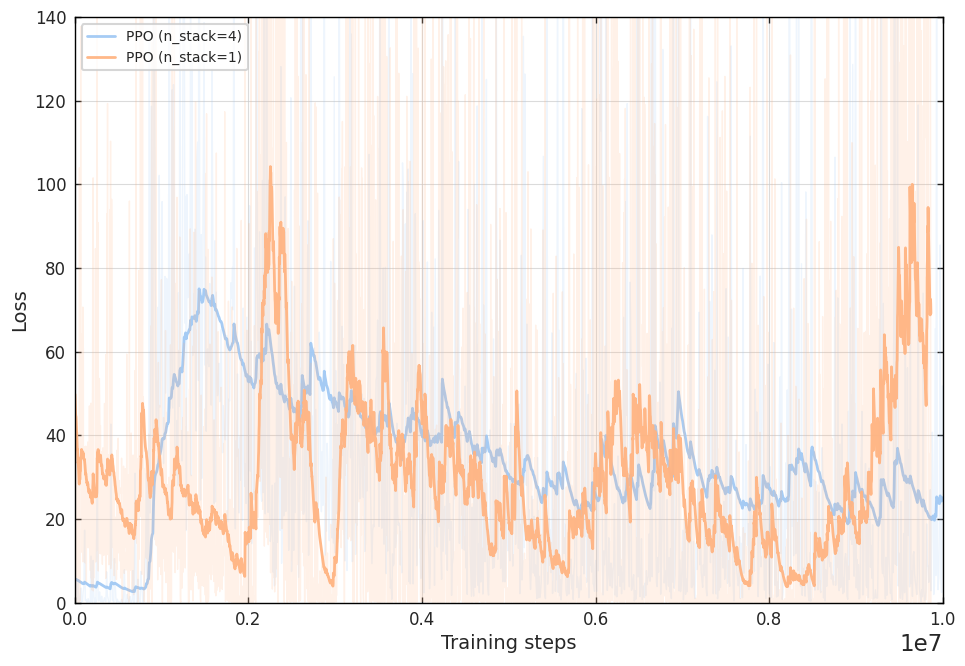

[MULTI] Saved combined loss figure to: figures/ppo_comparison_loss.pdf


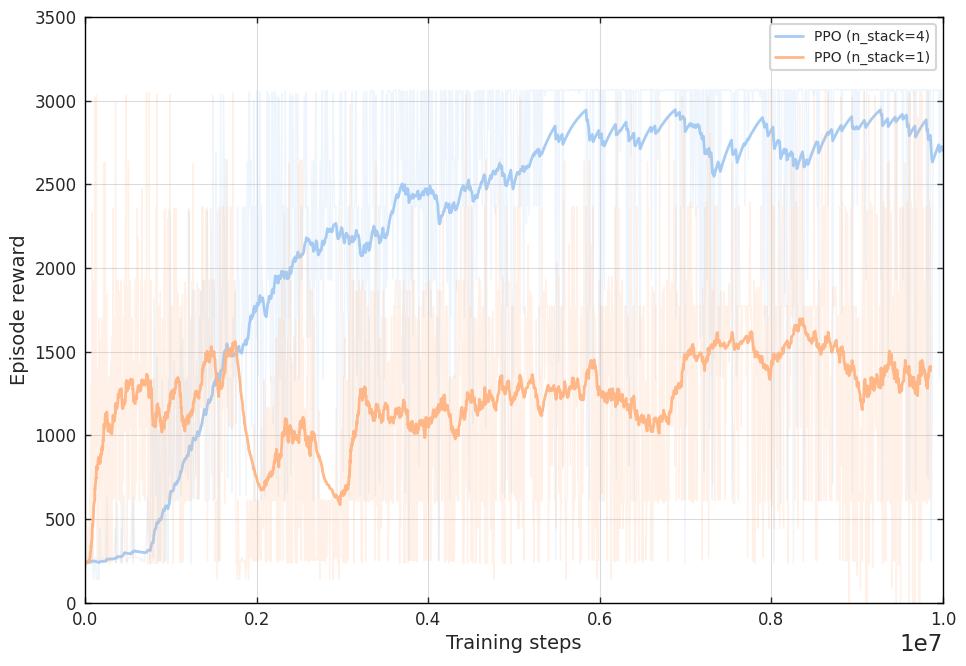

[MULTI] Saved combined reward figure to: figures/ppo_comparison_reward.pdf


In [23]:

RUN_CONFIGS = [
    {
        "run_name": "ppo_ram_run_20251121_173245",
        "log_dir": "/home/lucas_ccwj/projects/mario-rl/logs/ppo_ram_notebook/run_20251121_173245/PPO_1",
    },
    {
        "run_name": "ppo_mario_ram",
        "log_dir": "/home/lucas_ccwj/projects/mario-rl/logs/ppo_mario_ram/PPO_1",
    },
]

LEGEND_LABELS = [
    "PPO (n_stack=4)",
    "PPO (n_stack=1)",
]

plot_sb3_loss_reward_multi(
    run_configs=RUN_CONFIGS,
    legend_labels=LEGEND_LABELS,    # <--- lista de nombres en la leyenda
    use_smoothing=True,
    smoothing_weight=0.97,
    loss_x_range=(0, 10_000_000),
    loss_y_range=(0, 140),
    rew_x_range=(0, 10_000_000),
    rew_y_range=(0, 3_500),
    output_dir="figures",
    multi_name="ppo_comparison",
)

[ppo_ram_run_20251121_173245] Using event file: /home/lucas_ccwj/projects/mario-rl/logs/ppo_ram_notebook/run_20251121_173245/PPO_1/events.out.tfevents.1763771566.CCWJ-AI-PC.1217457.0
[ppo_ram_run_20251121_173245] Available scalar tags:
  - episode/flag
  - episode/flag_success_rate
  - episode/length
  - episode/max_x
  - episode/reward
  - rollout/ep_len_mean
  - rollout/ep_rew_mean
  - time/fps
  - train/approx_kl
  - train/clip_fraction
  - train/clip_range
  - train/entropy_loss
  - train/explained_variance
  - train/learning_rate
  - train/loss
  - train/policy_gradient_loss
  - train/value_loss
[ppo_ram_run_20251121_173245] Using loss tag:   train/loss
[ppo_ram_run_20251121_173245] Using reward tag: episode/reward


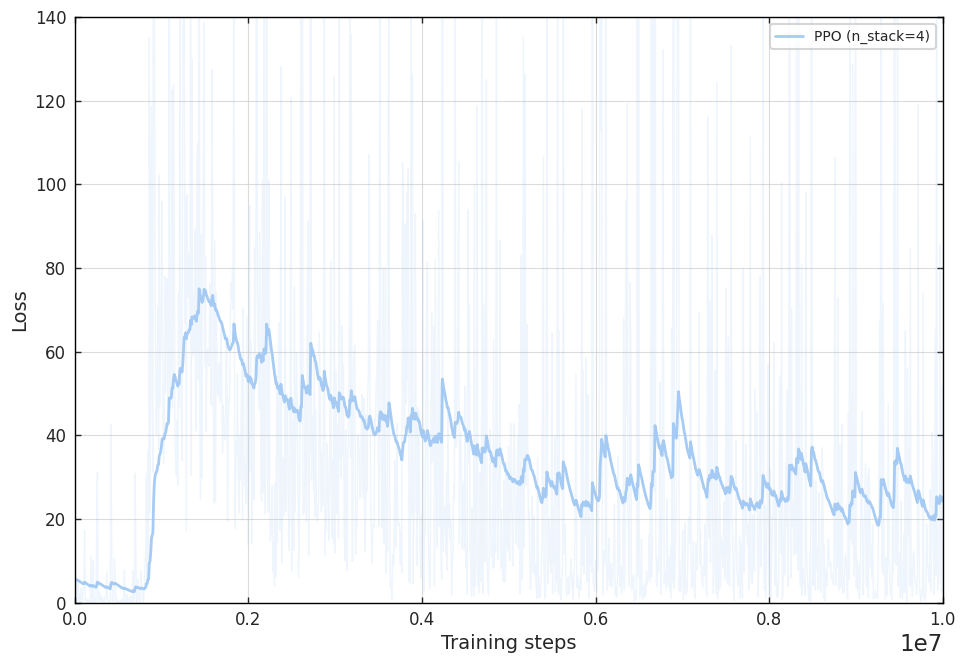

[ppo_ram_run_20251121_173245] Saved loss figure to: figures/ppo_ram_run_20251121_173245_loss.pdf


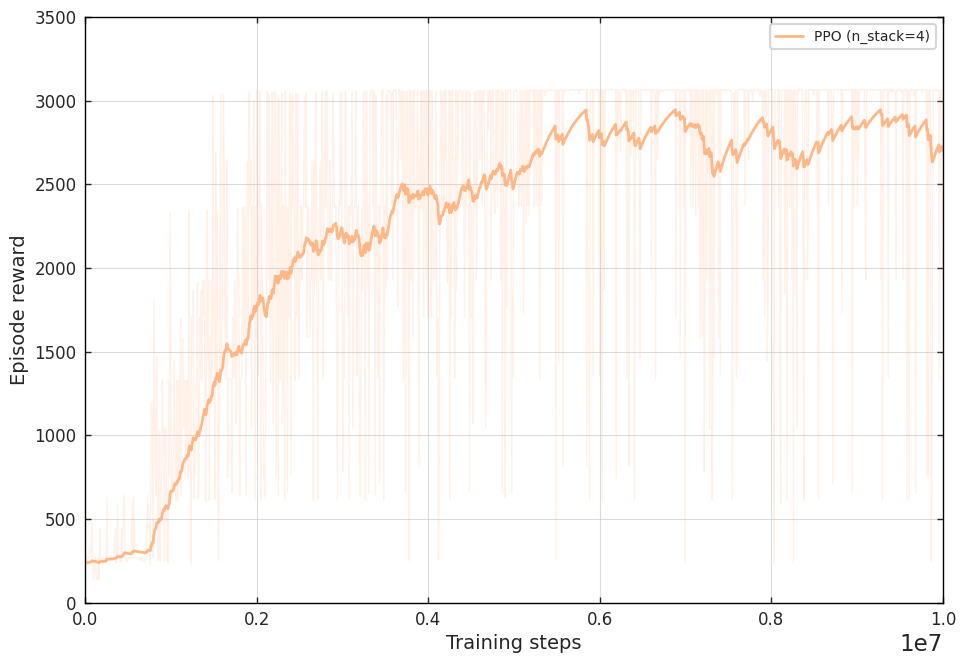

[ppo_ram_run_20251121_173245] Saved reward figure to: figures/ppo_ram_run_20251121_173245_reward.pdf


In [25]:
plot_sb3_loss_reward_separate(
    log_dir="/home/lucas_ccwj/projects/mario-rl/logs/ppo_ram_notebook/run_20251121_173245/PPO_1",
    run_name="ppo_ram_run_20251121_173245",
    legend_label="PPO (n_stack=4)",   # texto que aparecerá en la leyenda
    use_smoothing=True,
    smoothing_weight=0.97,
    loss_x_range=(0, 10_000_000),
    loss_y_range=(0, 140),
    rew_x_range=(0, 10_000_000),
    rew_y_range=(0, 3_500),
    output_dir="figures",
)